# Measure community edge properties, and output edges > sim thresh for all communities, for Figures 2,4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random


# latex rendering of text in graphs
import matplotlib as mpl

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys
from IPython.display import display

% matplotlib inline

In [2]:
from ddot import Ontology

# load cosine edge list, and gene to cluster matrix

In [3]:
gene2term_full= pd.read_csv('new_clixo_files/gene2term_full_01_45.csv',index_col='Unnamed: 0')
display(gene2term_full.head())

sim_rank_EL = pd.read_csv('new_clixo_files/sim_rank_cosine_EL.tsv',sep='\t',names=['node1','node2','sim'])
display(sim_rank_EL.head())

,844,845,846,847,848,849,850,851,852,853,...,954,955,956,957,958,959,960,961,962,963
AC008575.1,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,True,False,True,True,True,True
AC067968.1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
ACHE,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,True
ACTB,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,True,False,True,True
ACTN2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,True,True,False,True


,node1,node2,sim
0,SMARCC2,HIST1H4B,0.981613
1,SMARCC2,ZCCHC11,0.760676
2,SMARCC2,SMARCC1,1.000000
3,SMARCC2,ZDHHC12,0.212930
4,SMARCC2,HIST1H4J,0.983393


In [4]:
len(sim_rank_EL)

355746

In [5]:
# reshape sim_rank edge list into adjacency matrix (takes a few minutes)
ASD_CHD_genes = gene2term_full.index.tolist()
sim_rank = pd.DataFrame(np.zeros((len(ASD_CHD_genes),len(ASD_CHD_genes))),index=ASD_CHD_genes)
sim_rank.columns=ASD_CHD_genes

for i in sim_rank_EL.index.tolist():
    if (i%10000)==0:
        print(i) # print out some progress
    focal_row=sim_rank_EL.loc[i]
    focal_gene1=focal_row['node1']
    focal_gene2=focal_row['node2']
    focal_norm_cos_sim = focal_row['sim']
    
    sim_rank.loc[focal_gene1][focal_gene2]=focal_norm_cos_sim
    sim_rank.loc[focal_gene2][focal_gene1]=focal_norm_cos_sim # symmetric
    
sim_rank.head()

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000


,AC008575.1,AC067968.1,ACHE,ACTB,ACTN2,ACTN4,ADAM17,ADGRL2,ADNP,AFDN,...,ZNF532,ZNF536,ZNF638,ZNF644,ZNF652,ZNF740,ZNF865,ZSWIM8,ZZEF1,ZZZ3
AC008575.1,0.000000,0.341637,0.310795,0.558719,0.247034,0.699585,0.770166,0.301601,0.589561,0.928529,...,0.251186,0.278470,0.236655,0.250297,0.252669,0.330664,0.448992,0.306643,0.261269,0.253262
AC067968.1,0.341637,0.000000,0.255042,0.494662,0.529359,0.185053,0.196323,0.245848,0.526690,0.201364,...,0.195433,0.980724,0.530842,0.484579,0.664887,0.274911,0.393238,0.250890,0.205516,0.731613
ACHE,0.310795,0.255042,0.000000,0.612100,0.874259,0.154211,0.637604,0.832740,0.403025,0.630486,...,0.434757,0.789146,0.314947,0.385824,0.514531,0.244069,0.362396,0.220047,0.571471,0.481613
ACTB,0.558719,0.494662,0.612100,0.000000,0.890273,0.988731,0.620700,0.341044,0.735469,0.629893,...,0.657770,0.491696,0.655397,0.513938,0.487544,0.338671,0.279656,0.499110,0.565243,0.613286
ACTN2,0.247034,0.529359,0.874259,0.890273,0.000000,0.994662,0.501186,0.902728,0.547450,0.424377,...,0.682384,0.838078,0.476868,0.295374,0.304864,0.180308,0.298636,0.409253,0.356465,0.545374


# Measure the fraction internal to external edges for a focal cluster

In [6]:
focal_term = '901'
focal_genes = gene2term_full[gene2term_full[focal_term]==True].index.tolist()
print(len(focal_genes))
non_focal_genes = np.setdiff1d(gene2term_full.index.tolist(),focal_genes)

# pick genes randomly
focal_genes_rand = gene2term_full.index.tolist()
np.random.shuffle(focal_genes_rand)
focal_genes_rand=focal_genes_rand[0:len(focal_genes)]
non_focal_genes_rand = np.setdiff1d(gene2term_full.index.tolist(),focal_genes_rand)
sim_rank_focal = sim_rank.loc[focal_genes].T.loc[focal_genes]
sim_rank_focal_ext = sim_rank.loc[focal_genes].T.loc[non_focal_genes]

sim_rank_focal_rand = sim_rank.loc[focal_genes_rand].T.loc[focal_genes_rand]
sim_rank_focal_ext_rand = sim_rank.loc[focal_genes_rand].T.loc[non_focal_genes_rand]

# set diag to 0 (only internal, not external)
sim_rank_focal.values[[np.arange(sim_rank_focal.shape[0])]*2] = 0
sim_rank_focal_rand.values[[np.arange(sim_rank_focal_rand.shape[0])]*2] = 0
sim_rank_focal.head()

22


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


,ARHGEF7,ARID1A,ASXL1,ATXN2,BRD2,CHD8,EP400,FAM193A,GSE1,HECTD4,...,NPIPA1,PAPD7,PRR11,RNF44,SCAF4,SETD5,SFSWAP,SIN3B,TAOK1,TSC1
ARHGEF7,0.000000,0.806940,0.816726,0.790036,0.622776,0.752076,0.927046,0.954923,0.799526,0.812574,...,0.956109,0.892052,0.453440,0.913405,0.722420,0.786477,0.812574,0.623962,0.680012,0.862396
ARID1A,0.806940,0.000000,0.982800,0.807829,0.966192,0.949288,0.942171,0.946619,0.918743,0.685647,...,0.887307,0.954923,0.605575,0.782918,0.705219,0.879893,0.842823,0.976275,0.589561,0.730130
ASXL1,0.816726,0.982800,0.000000,0.901542,0.906287,0.883155,0.951068,0.971827,0.916370,0.788553,...,0.868921,0.994069,0.601423,0.970047,0.794187,0.969158,0.878410,0.929419,0.536180,0.731613
ATXN2,0.790036,0.807829,0.901542,0.000000,0.846382,0.951957,0.913405,0.982800,0.905694,0.956702,...,0.922301,0.908660,0.611803,0.761566,0.851127,0.951957,0.806346,0.728944,0.740807,0.880783
BRD2,0.622776,0.966192,0.906287,0.846382,0.000000,0.989917,0.965599,0.940095,0.719454,0.668446,...,0.954626,0.790332,0.774614,0.676750,0.817616,0.902135,0.905694,0.974496,0.822064,0.736062


In [7]:
# decrease edge threshold and count number of edges

# calculate the number of interenal edges to the number external edges
thresh_list = np.linspace(.999,0,25)
num_edges_internal_list = []
num_edges_internal_rand_list = []
num_edges_external_list = []
num_edges_external_rand_list = []
for thresh in thresh_list:
    num_focal_edges = (sim_rank_focal>thresh).sum().sum()/2.0 # don't double count
    num_edges_internal_list.append(num_focal_edges)
    
    num_focal_edges = (sim_rank_focal_ext>thresh).sum().sum()
    num_edges_external_list.append(num_focal_edges)
    
    num_rand_edges = (sim_rank_focal_rand>thresh).sum().sum()/2.0 # don't double count
    num_edges_internal_rand_list.append(num_rand_edges)
    
    num_rand_edges = (sim_rank_focal_ext_rand>thresh).sum().sum()
    num_edges_external_rand_list.append(num_rand_edges)

In [24]:
focal_term = '901'
focal_genes = gene2term_full[gene2term_full[focal_term]==True].index.tolist()
print(len(focal_genes))
non_focal_genes = np.setdiff1d(gene2term_full.index.tolist(),focal_genes)

numreps=100
# pick genes randomly
num_edges_internal_rand=[]
num_edges_external_rand=[]
for n in np.arange(numreps):  # just loop over both rand and non-rand... even though we only need to calc non-rand once (laziness)
    if n%10==0:
        print(n)
    focal_genes_rand = gene2term_full.index.tolist()
    np.random.shuffle(focal_genes_rand)
    focal_genes_rand=focal_genes_rand[0:len(focal_genes)]
    non_focal_genes_rand = np.setdiff1d(gene2term_full.index.tolist(),focal_genes_rand)
    sim_rank_focal = sim_rank.loc[focal_genes].T.loc[focal_genes]
    sim_rank_focal_ext = sim_rank.loc[focal_genes].T.loc[non_focal_genes]

    sim_rank_focal_rand = sim_rank.loc[focal_genes_rand].T.loc[focal_genes_rand]
    sim_rank_focal_ext_rand = sim_rank.loc[focal_genes_rand].T.loc[non_focal_genes_rand]

    # set diag to 0 (only internal, not external)
    sim_rank_focal.values[[np.arange(sim_rank_focal.shape[0])]*2] = 0
    sim_rank_focal_rand.values[[np.arange(sim_rank_focal_rand.shape[0])]*2] = 0
    sim_rank_focal.head()

    # decrease edge threshold and count number of edges

    # calculate the number of interenal edges to the number external edges
    thresh_list = np.linspace(.999,0,25)
    num_edges_internal_list = []
    num_edges_internal_rand_list = []
    num_edges_external_list = []
    num_edges_external_rand_list = []
    for thresh in thresh_list:
        num_focal_edges = (sim_rank_focal>thresh).sum().sum()/2.0 # don't double count
        num_edges_internal_list.append(num_focal_edges)

        num_focal_edges = (sim_rank_focal_ext>thresh).sum().sum()
        num_edges_external_list.append(num_focal_edges)

        num_rand_edges = (sim_rank_focal_rand>thresh).sum().sum()/2.0 # don't double count
        num_edges_internal_rand_list.append(num_rand_edges)

        num_rand_edges = (sim_rank_focal_ext_rand>thresh).sum().sum()
        num_edges_external_rand_list.append(num_rand_edges)
    num_edges_internal_rand.append(num_edges_internal_rand_list)
    num_edges_external_rand.append(num_edges_external_rand_list)
    

22
0


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


10
20
30
40
50
60
70
80
90


(0, 1.03)

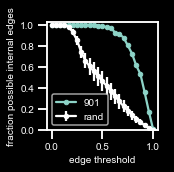

In [40]:
plt.figure(figsize=(2,2))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
plt.style.use("dark_background")
num_edges_int_rand_mean = np.mean(num_edges_internal_rand,axis=0)
num_edges_int_rand_std = np.std(num_edges_internal_rand,axis=0)

plt.plot(thresh_list,np.divide(num_edges_internal_list,num_edges_internal_list[-1]),'.-',label=focal_term)
#plt.plot(thresh_list,np.divide(num_edges_int_rand_mean,num_edges_int_rand_mean[-1]),'k.-',label='rand')
plt.errorbar(thresh_list,np.divide(num_edges_int_rand_mean,num_edges_int_rand_mean[-1]),
             np.divide(num_edges_int_rand_std,num_edges_int_rand_mean[-1]),
             fmt='.-',color='white',label='rand')
plt.xlabel('edge threshold',fontsize=10)
plt.ylabel('fraction possible internal edges',fontsize=10)
plt.legend(loc='best',fontsize=10)
plt.xticks([0,.5,1],fontsize=10)
plt.yticks([0,.2,.4,.6,.8,1.0],fontsize=10)
# plt.savefig('new_clixo_files/figures/community_edge_structure/fraction_internal_edges_'+focal_term+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../../manuscript/figures_1911/Supplement/fraction_internal_edges_'+focal_term+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../../manuscript/figures_1911/Supplement/fraction_internal_edges_'+focal_term+'.svg',dpi=300,bbox_inches='tight')
plt.ylim([0,1.03])

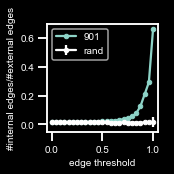

In [41]:
plt.figure(figsize=(2,2))

rand_int_ext_mean = np.mean(np.divide(num_edges_internal_rand,num_edges_external_rand),axis=0)
rand_int_ext_std = np.std(np.divide(num_edges_internal_rand,num_edges_external_rand),axis=0)

plt.plot(thresh_list,np.divide(num_edges_internal_list,num_edges_external_list),'.-',label=focal_term)
# plt.plot(thresh_list,np.divide(num_edges_internal_rand_list,num_edges_external_rand_list),'k.-',label='rand')
plt.errorbar(thresh_list,rand_int_ext_mean,rand_int_ext_std,
             fmt='.-',color='white',label='rand')
plt.legend(loc='best',fontsize=10)
plt.ylabel('#internal edges/#external edges',fontsize=10)
plt.xlabel('edge threshold',fontsize=10)
plt.xticks([0,.5,1],fontsize=10)
plt.yticks([0,.2,.4,.6],fontsize=10)
# plt.savefig('new_clixo_files/figures/community_edge_structure/ratio_interna_external_edges_'+focal_term+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../../manuscript/figures_1911/Supplement/ratio_interna_external_edges_'+focal_term+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../../manuscript/figures_1911/Supplement/ratio_interna_external_edges_'+focal_term+'.svg',dpi=300,bbox_inches='tight')

# write out edgelists for root cluster

Then import to cytoscape along with gene2term_full, and can create any community subgraph there

In [23]:
root_term='963'

In [26]:
focal_genes = gene2term_full[gene2term_full[root_term]==True].index.tolist()
print(len(focal_genes))

focal_sim_rank = sim_rank.loc[focal_genes][focal_genes]
focal_sim_rank.head()

simthresh=0.95
# simthresh=0.95

node1list,node2list,simlist = [],[],[]
genelist = focal_sim_rank.index.tolist()
for i in np.arange(len(genelist)-1):
    for j in np.arange(i+1,len(genelist)):
        node1=genelist[i]
        node2=genelist[j]
        sim = sim_rank.loc[node1][node2]
        
        if sim>simthresh: # only save strong edges... better for viz
            node1list.append(node1)
            node2list.append(node2)
            simlist.append(sim)
        
# add self-edges so we don't leave out unconnected nodes
for n1 in genelist:
    node1list.append(n1)
    node2list.append(n1)
    simlist.append(sim)
print(len(simlist))
root_sim_rank_EL = pd.DataFrame({'node1':node1list,'node2':node2list,'sim':simlist})


root_sim_rank_EL.head()  

# root_sim_rank_EL.to_csv('new_clixo_files/root_node_edges_'+str(simthresh)+'.tsv',sep='\t',index=False)

844
9480
